# 技术分析策略和交易系统_CCI指标的策略实现

In [1]:
import numpy as np
import pandas as pd
import talib as ta
import tushare as ts
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# 确保可以显示‘-’号
mpl.rcParams['axes.unicode_minus']=False
# 确保中文显示正常
mpl.rcParams['font.sans-serif'] = ['SimHei']  

### 1. 数据获取和数据处理

In [2]:
# 获得历史数据并按时间升序排序
stock = ts.get_h_data('600030', '2016-06-01', '2017-06-30')
stock.sort_index(inplace=True)
stock.head()

[Getting data:]####

,open,high,close,low,volume,amount
date,,,,,,
2016-06-01,16.00,16.14,15.79,15.78,116695922.0,1.949830e+09
2016-06-02,15.79,15.93,15.82,15.65,77142114.0,1.278391e+09
2016-06-03,15.86,16.09,15.84,15.71,115413775.0,1.920685e+09
2016-06-06,15.87,15.92,15.69,15.65,55176173.0,9.119408e+08
2016-06-07,15.74,15.86,15.72,15.66,59436762.0,9.817197e+08


In [3]:
# 计算CCI，取时间周期为20
stock['cci'] = ta.CCI(np.asarray(stock['high']), np.asarray(stock['low']), np.asarray(stock['close']), timeperiod=20)

In [4]:
stock.tail()

,open,high,close,low,volume,amount,cci
date,,,,,,,
2017-06-26,16.62,17.08,16.94,16.58,211319532.0,3.640808e+09,229.588926
2017-06-27,16.93,16.96,16.79,16.74,92402416.0,1.585190e+09,172.362179
2017-06-28,16.76,16.95,16.77,16.69,87105025.0,1.494473e+09,135.465245
2017-06-29,16.76,16.87,16.77,16.66,66834132.0,1.140796e+09,107.891290
2017-06-30,16.70,16.79,16.70,16.50,75109183.0,1.274741e+09,73.369026


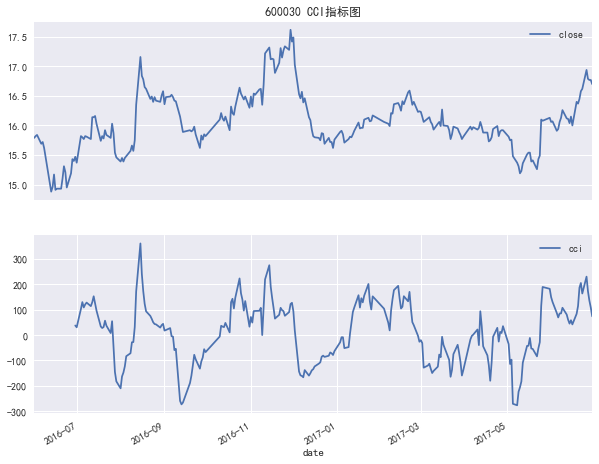

In [5]:
# 绘制cci指标图
plt.subplot(2, 1, 1)
plt.title('600030 CCI指标图')
plt.gca().axes.get_xaxis().set_visible(False)
stock['close'].plot(figsize = (10,8))
plt.legend()
plt.subplot(2, 1, 2)
stock['cci'].plot(figsize = (10,8))
plt.legend()
plt.show()

### 2. 交易信号和策略逻辑

#### 2.1 产生交易信号；

In [6]:
# 产生开仓信号时应使用昨日及前日cci，以避免未来数据
stock['yes_cci'] = stock['cci'].shift(1)
stock['daybeforeyes_cci'] = stock['cci'].shift(2)

In [7]:
# 产生开平仓信号
# 开多信号：当前二日cci小于-100，昨日cci大于-100则记为开多信号
stock['signal'] = np.where(np.logical_and(stock['daybeforeyes_cci']<-100, stock['yes_cci']>-100), 1, 0)

# stock['signal'] = np.where((stock['daybeforeyes_cci']<-100) & (stock['yes_cci']>-100), 1, 0)

# 开空信号：当前二日cci大于100， 昨日cci小于100则记为开空信号
stock['signal'] = np.where(np.logical_and(stock['daybeforeyes_cci']>100, stock['yes_cci']<100),-1, stock['signal'])


In [ ]:
stock.tail()

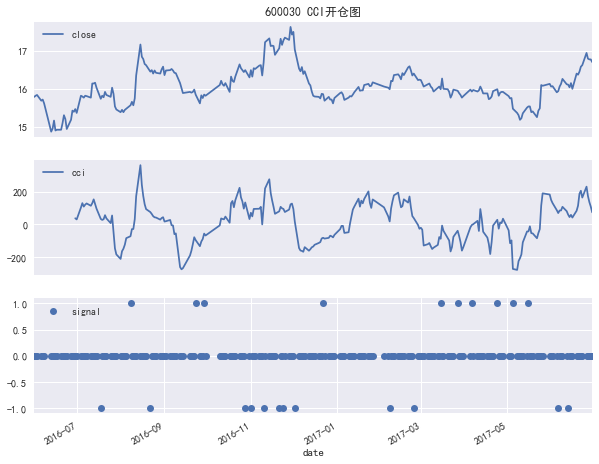

In [8]:
plt.subplot(3, 1, 1)
plt.title('600030 CCI开仓图')
plt.gca().axes.get_xaxis().set_visible(False)
stock['close'].plot(figsize = (10,8))
plt.legend(loc='upper left')
plt.subplot(3, 1, 2)
stock['cci'].plot(figsize = (10,8))
plt.legend(loc='upper left')
plt.gca().axes.get_xaxis().set_visible(False)
plt.subplot(3, 1, 3)
stock['signal'].plot(figsize = (10,8),marker='o',linestyle='')

plt.legend(loc='upper left')
plt.show()

#### 2.2 计算持仓

In [9]:
# 如果当天没有交易信号，设置为nan，如果有，取原来信号
stock['signal'] = np.where(stock['signal']==0, np.nan, stock['signal'])
# 通过前向填充生成持仓记录
stock['position'] = stock['signal'].fillna(method='ffill')

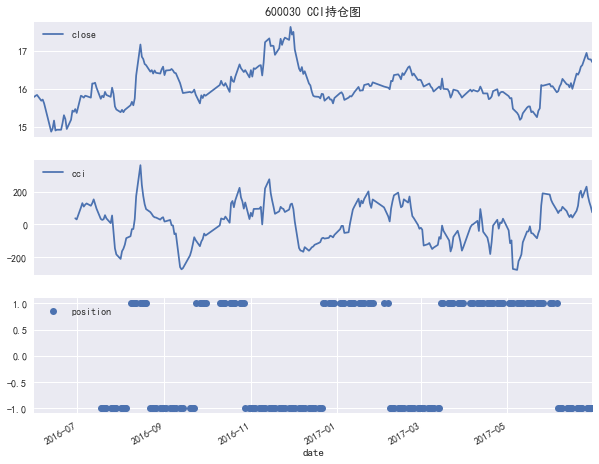

In [10]:
plt.subplot(3, 1, 1)
plt.title('600030 CCI持仓图')
plt.gca().axes.get_xaxis().set_visible(False)
stock['close'].plot(figsize = (12,12))
plt.legend(loc='upper left')
plt.subplot(3, 1, 2)
stock['cci'].plot(figsize = (12,12))
plt.legend(loc='upper left')
plt.gca().axes.get_xaxis().set_visible(False)
plt.subplot(3, 1, 3)
stock['position'].plot(marker='o', figsize=(10,8),linestyle='')
plt.legend(loc='upper left')
plt.show()

### 3. 收益计算和净值绘制

In [ ]:
# 计算策略收益
# 计算股票每日收益率
stock['pct_change'] = stock['close'].pct_change()
# 计算策略每日收益率
stock['strategy_return'] = stock['pct_change'] * stock['position']
# 计算股票累积收益率
stock['return'] = (stock['pct_change']+1).cumprod()
# 计算策略累积收益率
stock['strategy_cum_return'] = (1 + stock['strategy_return']).cumprod()

In [ ]:
stock.head()

In [ ]:
# 将股票累积收益率和策略累积收益率绘图
stock[['return', 'strategy_cum_return']].plot(figsize = (12,6))

plt.title('600030 CCI收益图')
plt.legend(loc='upper left')
plt.show()

声明：本资料仅供内部学习交流使用，切勿外传。